In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms, models
import time
torch.__version__

'1.2.0'

In [41]:
def convrelu(in_channels, out_channels, kernel, padding, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride=stride, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class MyFCN_diy_all(nn.Module):
    def __init__(self, ResidualBlock=ResidualBlock, num_classes=30):
        super().__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  1, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 1, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 1, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 1, stride=2)
        #self.fc = nn.Linear(512, 10)
        
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        #out = out.view(out.size(0), -1)
        #out = self.fc(out)
        return out

In [42]:
m = models.resnet50(pretrained=True)
ch = list(m.children())

In [20]:
for i in range(len(ch)):
    print(ch[i]) #0 3 5 6 7

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [43]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''
    return a bilinear filter tensor
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).cuda()

class MyFCN(nn.Module):
    def __init__(self, n_class):
        self.n_class = n_class
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_layers = list(self.base_model.children())
        
        self.layer00 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=100, bias=False)
        self.layer0 = nn.Sequential(*self.base_layers[1:4]) # size=(N, 64, x.H/4, x.W/4)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        
        self.layer1 = nn.Sequential(*self.base_layers[4]) # size=(N, 256, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(256, 256, 1, 0)
        
        self.layer2 = self.base_layers[5]  # size=(N, 512, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(512, 512, 1, 0)
        
        self.layer3 = self.base_layers[6]  # size=(N, 1024, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(1024, 1024, 1, 0)
        
        self.layer4 = self.base_layers[7]  # size=(N, 2048, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(2048, 2048, 1, 0)
        
        self.conv0 = convrelu(2048, 4096, 7, 0)
        #self.conv0 = convrelu(2048, 4096, 1, 0)
        self.conv1 = convrelu(4096, 4096, 1, 0)
        
        self.scores1 = nn.Conv2d(4096, n_class, kernel_size=1, stride=1, padding=0, bias=False)
        self.scores2 = nn.Conv2d(1024, n_class, kernel_size=1, stride=1, padding=0, bias=False)
        self.scores3 = nn.Conv2d(512, n_class, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.upsample_8x = nn.ConvTranspose2d(n_class, n_class, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(n_class, n_class, 16) # 使用双线性 kernel
        
        self.upsample_4x = nn.ConvTranspose2d(n_class, n_class, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(n_class, n_class, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(n_class, n_class, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(n_class, n_class, 4) # 使用双线性 kernel
        
    def forward(self, input):
        # the base net
        layer0 = self.layer00(input)
        layer0 = self.layer0(layer0)
        layer0 = self.layer0_1x1(layer0) 
        
        layer1 = self.layer1(layer0)
        layer1 = self.layer1_1x1(layer1)
        
        layer2 = self.layer2(layer1)
        layer2 = self.layer2_1x1(layer2)
        
        layer3 = self.layer3(layer2)
        layer3 = self.layer3_1x1(layer3)
        
        layer4 = self.layer4(layer3)
        layer4 = self.layer4_1x1(layer4)

        # fully conv
        fc5 = self.conv0(layer4)
        fc5 = F.dropout(fc5,p=0.5)
        fc5 = self.conv1(fc5)
        fc5 = F.dropout(fc5,p=0.5)
        fc5 = self.scores1(fc5)
        fc5 = self.upsample_2x(fc5)
        
        fc6 = self.scores2(layer3)
        fc6 = fc6[:,:,abs(fc6.size()[2]-fc5.size()[2])//2:fc5.size()[2]+abs(fc6.size()[2]-fc5.size()[2])//2,abs(fc6.size()[3]-fc5.size()[3])//2:fc5.size()[3]+abs(fc6.size()[3]-fc5.size()[3])//2]
        fc6 = fc6 + fc5
        fc6 = self.upsample_4x(fc6)

        fc7 = self.scores3(layer2)
        fc7 = fc7[:,:,abs(fc7.size()[2]-fc6.size()[2])//2:fc6.size()[2]+abs(fc7.size()[2]-fc6.size()[2])//2,abs(fc7.size()[3]-fc6.size()[3])//2:fc6.size()[3]+abs(fc7.size()[3]-fc6.size()[3])//2]
        fc7 = fc7 + fc6
        fc7 = self.upsample_8x(fc7)
        
        out = fc7[:,:,abs(fc7.size()[2]-input.size()[2])//2:input.size()[2]+abs(fc7.size()[2]-input.size()[2])//2,abs(fc7.size()[3]-input.size()[3])//2:input.size()[3]+abs(fc7.size()[3]-input.size()[3])//2]
        return out

In [44]:
from torchviz import make_dot
from torch.autograd import Variable
from torchsummary import summary


net = MyFCN(20)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net,device_ids=[0])
net.to(device)

#summary(net, input_size=(3, 224, 224))
#x = Variable(torch.randn(1,3,300,300))

#model(x)
#vis_graph = make_dot(model(x), params=dict(model.named_parameters()))
#vis_graph.view()

DataParallel(
  (module): MyFCN(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

In [5]:
x = Variable(torch.randn(1,3,224,224)).cuda()
result = net(x)
result.size()

torch.Size([1, 20, 224, 224])

# 分割线

---

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset,DataLoader

In [21]:
voc_root = '/home/hyf/datasets/LIP/'

def read_images(root=voc_root, train=True):
    txt_fname = root  + ('train_id.txt' if train else 'val_id.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, ('train_images/' if train else 'val_images/')+i+'.jpg') for i in images]
    label = [os.path.join(root, ('train_segmentations/' if train else 'val_segmentations/')+i+'.png') for i in images]
    return data, label

In [22]:
def rand_crop(data, label, height, width):
    
    #data is PIL.Image object
    #label is PIL.Image object
    
    data, rect = transforms.RandomCrop((height, width))(data)
    label = transforms.FixedCrop(*rect)(label)
    return data, label

In [23]:
classes = ['background','Hat','Hair','Glove','Sunglasses','UpperClothes',
           'Dress','Coat','Socks','Pants','Jumpsuits','Scarf','Skirt',
           'Face','Left-arm','Right-arm','Left-leg','Right-leg',
           'Left-shoe','Right-shoe']

# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,128]]

len(classes), len(colormap)

(20, 20)

In [24]:
def png2color(im):
    data = np.array(im, dtype='int32')
    return np.array([colormap[i] for cols in data.tolist() for i in cols], dtype='uint8').reshape(data.shape[0],data.shape[1],3) # 根据索引得到color图

def png2label(im):
    L = np.asarray(np.array(im), np.int64)
    return  L.copy()

(120, 104)


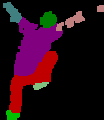

In [25]:
label_im = Image.open('/home/hyf/datasets/LIP/train_segmentations/77_471474.png').convert('L')
color_image = png2color(label_im)
print(png2label(label_im).shape)
Image.fromarray(color_image)

In [26]:
def img_transforms(im, label):
    #im, label = rand_crop(im, label, *crop_size)
    im_tfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    im = im_tfs(im)
    label = png2label(label)
    label = torch.from_numpy(label)
    return im, label

In [38]:
class LIPSegDataset(Dataset):
    
    # LIP dataset
    
    def __init__(self, train, transforms):
        self.crop_size = [100,100]
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        self.data_list = data_list
        self.data_list = self._filter(self.data_list)
        self.label_list = label_list
        self.label_list = self._filter(self.label_list)
        _filter
        print('Read ' + str(len(self.data_list)) + ' images')
        
    def _filter(self, images): # 过滤掉图片大小小于 crop 大小的图片
        return [im for im in images if (Image.open(im).size[1] >= self.crop_size[0] and 
                                        Image.open(im).size[0] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('L')
        img, label = self.transforms(img, label)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [39]:
# 实例化数据集

lip_train = LIPSegDataset(True, img_transforms)
lip_val = LIPSegDataset(False, img_transforms)

train_data = DataLoader(lip_train, 1, shuffle=True, num_workers=8)
val_data = DataLoader(lip_val, 1,  num_workers=8)

KeyboardInterrupt: 

In [16]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    # Returns accuracy score evaluation result.
      # overall accuracy
      # mean accuracy
      # mean IU
      # fwavacc

    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

# 分割线
---

In [17]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, reduction='sum')
    if size_average:
        loss /= mask.data.sum()
    return loss

In [18]:
import torch.optim as optim
from datetime import datetime
from torch.optim import lr_scheduler

gamma      = 0.5
epochs     = 500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 50
use_gpu = True

BATCH_SIZE=512 #大概需要2G的显存
EPOCHS=20 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU，建议使用GPU环境，因为会快很多

criterion = cross_entropy2d
optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=momentum, weight_decay=w_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # decay LR by a factor of 0.5 every 30 epochs

In [25]:
inputs,labels = iter(train_data).next()
outputs = net(inputs.cuda())
outputs.size(),labels.size()

(torch.Size([1, 20, 586, 134]), torch.Size([1, 586, 134]))

In [35]:
outputs.transpose(1, 2).transpose(2, 3).contiguous()[labels.view(1, 586, 134, 1).repeat(1, 1, 1, 20) >= 0].view(-1, 20).size()

torch.Size([78524, 20])

In [32]:
def train():
    for epoch in range(epochs):
        scheduler.step()

        ts = time.time()
        for iter, batch in enumerate(train_data):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch[0].cuda())
                labels = Variable(batch[1].cuda())
            else:
                inputs, labels = Variable(batch[0]), Variable(batch[1])

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.data))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        #torch.save(net.state_dictdict(), voc_root)
        filepath = os.path.join(voc_root, 'checkpoint_model_epoch_{}.pth'.format(epoch)) #最终参数模型
        torch.save(net.state_dictdict(), filepath)
        #val(epoch)


def val(epoch):
    fcn_model.eval()
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch[0].cuda())
        else:
            inputs = Variable(batch[1])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            total_ious.append(iou(p, t))
            pixel_accs.append(pixel_acc(p, t))

    # Calculate average IoU
    total_ious = np.array(total_ious).T  # n_class * val_len
    ious = np.nanmean(total_ious, axis=1)
    pixel_accs = np.array(pixel_accs).mean()
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}".format(epoch, pixel_accs, np.nanmean(ious), ious))
    IU_scores[epoch] = ious
    np.save(os.path.join(score_dir, "meanIU"), IU_scores)
    pixel_scores[epoch] = pixel_accs
    np.save(os.path.join(score_dir, "meanPixel"), pixel_scores)

In [34]:
train()

epoch0, iter0, loss: 1.433695912361145
epoch0, iter10, loss: 1.1627378463745117
epoch0, iter20, loss: 1.0463087558746338
epoch0, iter30, loss: 1.3542354106903076
epoch0, iter40, loss: 1.1770009994506836
epoch0, iter50, loss: 1.3519755601882935
epoch0, iter60, loss: 1.482579231262207


RuntimeError: Caught RuntimeError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/home/hyf/.conda/envs/pytorch_hyfok/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/hyf/.conda/envs/pytorch_hyfok/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/hyf/.conda/envs/pytorch_hyfok/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-27-03b8bb0ac1a4>", line 22, in __getitem__
    img, label = self.transforms(img, label)
  File "<ipython-input-26-a4b6a8d2bfaa>", line 8, in img_transforms
    im = im_tfs(im)
  File "/home/hyf/.conda/envs/pytorch_hyfok/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 61, in __call__
    img = t(img)
  File "/home/hyf/.conda/envs/pytorch_hyfok/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 166, in __call__
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/home/hyf/.conda/envs/pytorch_hyfok/lib/python3.7/site-packages/torchvision/transforms/functional.py", line 217, in normalize
    tensor.sub_(mean[:, None, None]).div_(std[:, None, None])
RuntimeError: output with shape [1, 280, 110] doesn't match the broadcast shape [3, 280, 110]
